In [1]:
import cv2
# from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from threading import Thread

from scipy.spatial import Delaunay
# from skimage.io import imread
import scipy.misc

import dlib

In [2]:
# Data from: https://huggingface.co/datasets/wider_face
# unzip files into 'data' folder

data_dir            = 'data'

training_img_dir    = '/WIDER_train/images/'
test_img_dir        = '/WIDER_test/images/'
validation_img_dir  = '/WIDER_val/images/'

label_dir           = '/wider_face_split'
training_img_label  = '/wider_face_train_bbx_gt.txt'
val_img_label       = '/wider_face_val_bbx_gt.txt'

In [3]:
training_data = []

with open(data_dir + label_dir + training_img_label) as t:
    line = t.readline().strip('\n')
    num_img, max_img = 0, 50

    while line:
        if 'jpg' in line:
            num_img += 1
            if num_img > max_img:
                num_img -= 1
                break

            # If we need anything beyond bbx and img from data, 
            # uncomment the commented dictionary and data parsing bits below
            training_data.append({
                'img': cv2.cvtColor(cv2.imread(data_dir + training_img_dir + line, -1), cv2.COLOR_BGR2RGB),
                # 'img': Image.open(data_dir + training_img_dir + line),
                'bbx': [],
                # 'blur': [],
                # 'expression': [],
                # 'illumination': [],
                # 'occulsion': [],
                # 'pose': [],
                # 'invalid': []
            })

        else:
            if line.isnumeric(): # number of face bbx
                line = t.readline().strip('\n')
                continue
            else:
                face_data = line.split(' ')
                training_data[-1]['bbx'].append([int(coord) for coord in face_data[:4]])
                # training_data[-1]['blur'].append(int(face_data[4]))
                # training_data[-1]['expression'].append(int(face_data[5]))
                # training_data[-1]['illumination'].append(int(face_data[6]))
                # training_data[-1]['occulsion'].append(int(face_data[7]))
                # training_data[-1]['pose'].append(int(face_data[8]))
                # training_data[-1]['invalid'].append(not bool(face_data[9]))
        line = t.readline().strip('\n')

In [4]:
amongus_dir = data_dir + '/amongus'
among_us = [cv2.cvtColor(cv2.imread(f'{amongus_dir}/{file}', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)[140:650, 175:650] # resize config
            for file in os.listdir(amongus_dir)]

# crop_config = (175, 140, 650, 650) # left, top, right bottom
# among_us = [Image.open(f'{amongus_dir}/{file}').crop(crop_config)
#             for file in os.listdir(amongus_dir)]

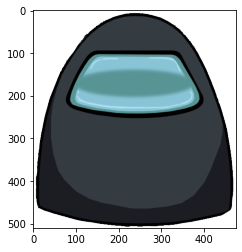

In [5]:
plt.imshow(among_us[0])
plt.show()


# Resize Amongus Face from BBX

1


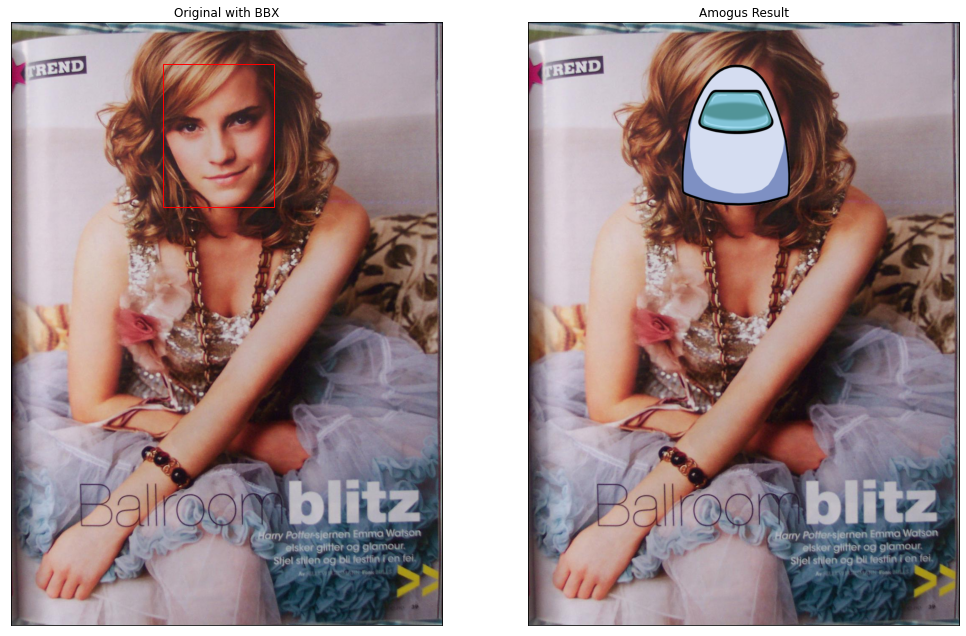

In [6]:
# i = np.random.randint(0, len(training_data))
i = 1
print(i)

train_img = training_data[i]['img']
res = train_img.copy()
threads = []

fig, axes = plt.subplots(1, 2, figsize=(17,20))
axes[0].imshow(train_img)
axes[0].set_title('Original with BBX'), axes[0].set_xticks([]), axes[0].set_yticks([])

def threading_amongus(bbx):
    a, b, width, height = bbx
    # resize a randomly chosen among-us face
    amongus = cv2.resize(among_us[np.random.randint(0, len(among_us))], (width, height), interpolation=cv2.INTER_AREA)

    # assign among-us face to the global result
    alpha = amongus[:, :, 3] / 255.0
    for channel in range(3):
        res[b:b+height, a:a+width, channel] = (1. - alpha) * train_img[b:b+height, a:a+width, channel] + alpha * amongus[:, :, channel]

    # add bounding box for the first image
    rect = patches.Rectangle((a, b), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)

# parallellize the resizing & assigning of amongus faces
for bbx in training_data[i]['bbx']:
    threads.append(Thread(target=threading_amongus, args=(bbx,)))
    threads[-1].start()

# join all threads
for thread in threads:
    thread.join()

axes[1].imshow(res)
axes[1].set_title('Amogus Result'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

# Detect Feature Points and Warp

In [46]:
a, b, width, height = bbx # image 1 only has 1 bbx
sub_img = train_img[b:b+height, a:a+width]
res_img = res[b:b+height, a:a+width]

def get_face_landmarks(img):
    detector = dlib.get_frontal_face_detector()
    # download predictor from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    predictor = dlib.shape_predictor('data/shape_predictor_68_face_landmarks.dat') 

    dets = detector(img, 1)
    if len(dets) == 0:
        dets = dlib.rectangles()
        dets.append(dlib.rectangle(-32, 0, img.shape[0], img.shape[1]))
    
    pts = np.zeros((68, 2), np.int32)

    for d in dets:
        
        shape = predictor(img, d) # get landmark

        for i in range(68):
            pts[i, 0] = shape.part(i).x
            pts[i, 1] = shape.part(i).y
    
    return pts

In [47]:
original_lm = get_face_landmarks(sub_img)
amongus_lm = get_face_landmarks(res_img) # should only be computed once

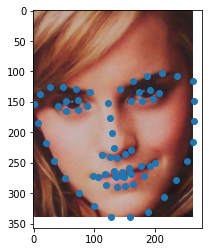

In [48]:
plt.imshow(sub_img)
plt.plot([x for x, _ in original_lm], [y for _, y in original_lm], 'o')
plt.show()

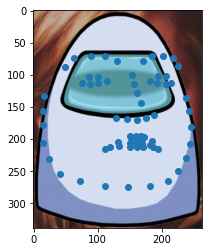

In [49]:
plt.imshow(res_img)
plt.plot([x for x, _ in amongus_lm], [y for _, y in amongus_lm], 'o')
plt.show()